In [2]:
import numpy as np
import scipy
import scipy.special as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from domain_class import domain

## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

In [3]:
from scipy.special import gammaln
import scipy.special as sp
from domain_class import domain
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

class Multipoles:
    def __init__(self, l_max, m_max, wl, domain, nr = 1, radius = None):
        self.l_max = l_max
        self.m_max = m_max
        
        #initialize available l and m values
        self.lvals = np.arange(0, l_max + 1)
        self.mvals = np.arange(-l_max, l_max + 1)
        
        if m_max not in self.mvals:
            raise ValueError(f"m must be in range {-l_max} to {l_max}")

        self.wl = wl
        self.spherical_grids = domain.spherical_grid()
        self.size = domain.size
        
        self.nr = nr #relative refractive index
        
        #other initialized variables
        self.wn = 2 * np.pi / wl
        self.planes = self.spherical_grids.keys()
        
        # initialize arrays of spherical coordinates. shape = (Nplanes, shape(grid))
        self.R = np.array([self.spherical_grids[plane][0] for plane in self.planes])
        self.Theta = np.array([self.spherical_grids[plane][1] for plane in self.planes])
        self.Phi = np.array([self.spherical_grids[plane][2] for plane in self.planes])
        
        self.Leg = self.get_Legendre(l_max+1, m_max+1, np.cos(self.Theta))
        self.dLeg = self.get_Legendre(l_max+1, m_max+1, np.cos(self.Theta), diff = True)
        #self.Leg = np.swapaxes(self.Leg, -2, -1)
        #self.dLeg = np.swapaxes(self.dLeg, -2, -1)
        
        if not radius:
            self.rr = 0.25 * self.R.max() # Define the radius of the sphere
        else:
            self.rr = radius
        
        # Initialize SCA and ABS arrays with ones, same shape as R
        self.SCA = np.ones_like(self.R)
        self.ABS = np.ones_like(self.R)
        
        # Find indices where values are less than or greater than rr
        index1 = np.where(self.R < self.rr)
        index2 = np.where(self.R >= self.rr)

        # Set values in ABS and SCA arrays based on indices
        self.ABS[index2] = 0
        self.SCA[index1] = 0
        
        
    @staticmethod
    def Clp(l):
        #return -1j * np.sqrt(l / (2 * l + 1))
        return -1 * np.sqrt(l/(2*l+1))

    @staticmethod
    def Clm(l):
        #return 1j * np.sqrt((l + 1) / (2 * l + 1))
        return 1 * np.sqrt((l+1)/(2*l+1))

    @staticmethod
    def Cl0(l):
        #return -1j
        return -1

    @staticmethod
    def hankel(n, x, derivative=False):
        #Returns the spherical hankel function of the first kind or its derivative
        if not derivative:
            return sp.spherical_jn(n, x) + 1j * sp.spherical_yn(n, x)
        else:
            return sp.spherical_jn(n, x, derivative=True) + 1j * sp.spherical_yn(n, x, derivative=True)

    @staticmethod
    def clebsch_gordan(j1, j2, j, m1, m2, m):
        if any(2 * x != int(2 * x) for x in [j1, j2, j, m1, m2, m]):
            raise ValueError('All arguments must be integers or half-integers.')

        if m1 + m2 != m:
            return 0

        if not (j1 - m1 == int(j1 - m1)):
            return 0

        if not (j2 - m2 == int(j2 - m2)):
            return 0

        if not (j - m == int(j - m)):
            return 0

        if j > j1 + j2 or j < abs(j1 - j2):
            return 0

        if abs(m1) > j1:
            return 0

        if abs(m2) > j2:
            return 0

        if abs(m) > j:
            return 0

        m = float(m)
        cg = (-1) ** (j1 - j2 + m) * np.sqrt(2 * j + 1) * Multipoles.wigner_3j([j1, j2, j], [m1, m2, -m])
        return cg

    @staticmethod
    def wigner_3j(j123, m123):
        j1, j2, j3 = j123
        m1, m2, m3 = m123

        if any(np.array(j123) < 0):
            raise ValueError('The j values must be non-negative')
        elif any(np.mod(np.array(j123 + m123), 0.5) != 0):
            raise ValueError('All arguments must be integers or half-integers')
        elif any(np.mod(np.array(j123) - np.array(m123), 1) != 0):
            raise ValueError('j123 and m123 do not match')

        if (j3 > (j1 + j2)) or (j3 < abs(j1 - j2)) or (m1 + m2 + m3 != 0) or any(np.abs(m123) > j123):
            return 0

        if all(m == 0 for m in m123) and np.mod(np.sum(j123), 2) != 0:
            return 0

        t1 = j2 - m1 - j3
        t2 = j1 + m2 - j3
        t3 = j1 + j2 - j3
        t4 = j1 - m1
        t5 = j2 + m2

        tmin = max(0, max(t1, t2))
        tmax = min(t3, min(t4, t5))

        t = np.arange(tmin, tmax + 1)

        gam1 = -np.ones(6) @ gammaln(np.array([t, t - t1, t - t2, t3 - t, t4 - t, t5 - t]) + 1)
        gam2 = gammaln(np.array([j1 + j2 + j3 + 1, j1 + j2 - j3, j1 - j2 + j3, -j1 + j2 + j3,
                                    j1 + m1, j1 - m1, j2 + m2, j2 - m2, j3 + m3, j3 - m3]) + 1)

        gam2 = gam2 @ np.array([-1] + [1] * 9) * 0.5

        gamsum = np.squeeze(np.add.outer(gam1, gam2))

        w = np.sum((-1) ** t * np.exp(gamsum)) * (-1) ** (j1 - j2 - m3)

        if np.isnan(w):
            print('Warning: Wigner3J is NaN!')
        elif np.isinf(w):
            print('Warning: Wigner3J is Inf!')
        return w

    def vsh(self, j, l, m, theta, phi):
        """Calculate value of vector spherical harmonics for given j, l, m, theta, phi.

        Args:
            j (int): total angular momentum
            l (int): orbital angular momentum
            m (int): Jz 
            theta (array of floats): Grid array of theta values
            phi (array of floats): Grid of phi values
        
        Returns:
            VSH (array of floats): Grid array of vector spherical harmonics values  
        """
        cp = self.clebsch_gordan(l, 1, j, m - 1, 1, m)
        c0 = self.clebsch_gordan(l, 1, j, m, 0, m)
        cm = self.clebsch_gordan(l, 1, j, m + 1, -1, m)
        M = np.array([(cp != 0) * (m - 1), (c0 != 0) * m, (cm != 0) * (m + 1)])
        #Y = np.array([self.spharm(l, m_val, theta, phi) for m_val in M])
        Y = np.array([sp.sph_harm_y(l, m_val, theta, phi)*(-1)**abs(m_val) for m_val in M])
        Ap = cp * Y[0, :]
        A0 = c0 * Y[1, :]
        Am = cm * Y[2, :]

        return Ap, A0, Am

    def spharm(self, l, m, theta, phi):
        """Calculate the spherical harmonics for given l, m, theta, phi according to M.E. Rose, Elementary Theory of Angular Momentum, Wiley, 1957, App. 3.

        Args:
            l (int): Degree of the Legendre function
            m (int): Order of the Legendre function
            theta (array_like): Array of azimuthal angles
            phi (array_like): Array of polar angles

        Returns:
            Y: Array of spherical harmonics values Shape: (len(theta))
        """
        sgn = -2 * ((m < 0) - 0.5) # -1 if m is negative 1 if m is non-negative
        m = abs(m)
        
        leg = self.Leg[l, m] #*(-1)**m # Include the (-1)^m Condon-Shortley phase factor in the Legendre function
        e = np.exp(1j * (sgn * m) * phi) # azimuthal factor

        Y = leg * e / np.sqrt(2 * np.pi) 

        if sgn < 0 and m % 2 != 0:
            Y = -Y

        return Y

    def get_Legendre(self, l, m, theta, diff = False):
        """Calculate the associated Legendre functions up to degree l and order m.

        Args:
            l (int): Degree of the Legendre function
            m (int): Order of the Legendre function
            theta (array_like): Array of coordinates
            norm (bool, optional): Use the normalized Legendre function. Defaults to True.
            diff (bool, optional): Use the derivative of the Legendre function. Defaults to False.

        Returns:
            Array: (l+1,m+1, len(theta))
        """
        if not diff:
            diff_n = 0
        else:
            diff_n = 1
        Leg = sp.assoc_legendre_p_all(l, m, theta, norm = True, diff_n = diff_n) # sp returns shape (1, l+1, 2m+1, len(theta))
        Leg = Leg[0,:,:m+1] # shape (l, m, len(theta))
        
        return Leg

    def get_multipoles(self, l, m, spatial_fun="hankel"):
        
        #check if l and m exceed the maximum values defined
        if l > self.l_max:
            raise ValueError(f"l must be less than or equal to {self.l_max}")
        if m > self.m_max:
            raise ValueError(f"m must be less than or equal to {self.m_max}")
        
        # Define the spatial function based on the input
        if spatial_fun == "hankel":
            spatial_func = lambda l, x: self.hankel(l, x)
        elif spatial_fun == "bessel":
            spatial_func = lambda l, x: sp.spherical_jn(l, self.nr*x)
        elif spatial_fun == "both":
            spatial_func = lambda l, x: self.SCA*self.hankel(l, x) + self.ABS * sp.spherical_jn(l, self.nr*x)
        elif callable(spatial_fun):
            spatial_func = spatial_fun
        else:
            raise ValueError("spatial_fun must be 'hankel', 'bessel', 'both', or a callable function")      

        # VSH's
        Ap1, A01, Am1 = self.vsh(l, l, m, self.Theta, self.Phi)
        Ap1 = np.swapaxes(Ap1, -2, -1)
        A01 = np.swapaxes(A01, -2, -1)
        Am1 = np.swapaxes(Am1, -2, -1)
        spatial0 = spatial_func(l, self.wn * self.R)
        
        Alp_m_p = self.Cl0(l) * spatial0 * Ap1
        Alp_m_0 = self.Cl0(l) * spatial0 * A01
        Alp_m_m = self.Cl0(l) * spatial0 * Am1

        Ap2, A02, Am2 = self.vsh(l, l + 1, m, self.Theta, self.Phi)
        Ap3, A03, Am3 = self.vsh(l, l - 1, m, self.Theta, self.Phi)
        Ap2 = np.swapaxes(Ap2, -2, -1)
        A02 = np.swapaxes(A02, -2, -1)
        Am2 = np.swapaxes(Am2, -2, -1)
        Ap3 = np.swapaxes(Ap3, -2, -1)
        A03 = np.swapaxes(A03, -2, -1)
        Am3 = np.swapaxes(Am3, -2, -1)
        spatialp = spatial_func(l + 1, self.wn * self.R)
        spatialm = spatial_func(l - 1, self.wn * self.R)
        
        Alp_e_p = self.Clp(l) * spatialp * Ap2 + self.Clm(l) * spatialm * Ap3
        Alp_e_0 = self.Clp(l) * spatialp * A02 + self.Clm(l) * spatialm * A03
        Alp_e_m = self.Clp(l) * spatialp * Am2 + self.Clm(l) * spatialm * Am3

        P_magnetic = Alp_m_p
        Z_magnetic = Alp_m_0
        M_magnetic = Alp_m_m

        P_electric = Alp_e_p
        Z_electric = Alp_e_0
        M_electric = Alp_e_m
        
        #P_magnetic =  Ap1
        #Z_magnetic =  A01
        #M_magnetic = Am1

        #P_electric = self.Clp(l) * Ap2 + self.Clm(l) * Ap3
        #Z_electric = self.Clp(l) * A02 + self.Clm(l) * A03
        #M_electric = self.Clp(l) * Am2 + self.Clm(l) * Am3
        
        
        out = {
            "magnetic": np.array([P_magnetic, Z_magnetic, M_magnetic]),
            "electric": np.array([P_electric, Z_electric, M_electric])
        }
        
        return out

    
    def plot_multipoles(self, l, m, type = "magnetic", interaction = "scattering", plot = "components", globalnorm = False):
        assert type in ["magnetic", "electric"], "type must be 'magnetic' or 'electric'"
        assert interaction in ["scattering", "internal", "both"], "interaction must be 'scattering', 'internal', or 'both"
        assert plot in ["components", "total"], "plot must be 'components' or 'total'"
        
        if interaction == "scattering":
            spatial_fun = "hankel"
            S = self.SCA
        elif interaction == "internal":
            spatial_fun = "bessel"
            S = self.ABS
        elif interaction == "both":
            spatial_fun = "both"
            S = self.SCA + self.ABS
        else:
            raise ValueError("type must be 'scattering' or 'internal'")
        
        mp = self.get_multipoles(l, m, spatial_fun)
        
        
        if plot == "components":
            # Plot Nplanes x 3 subplots
            fig, axs = plt.subplots(len(self.planes), 3, figsize=(12, 4 * len(self.planes)))
            
            mp[type][:] = np.abs(mp[type][:])**2 * S
            if globalnorm:
                # Find the global min and max values for normalization
                vmin = np.min(np.abs(mp[type][:])) 
                vmax = np.max(np.abs(mp[type][:]))
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            else:
                norm = None
                
            fig.suptitle(f'{type.capitalize()} Multipole (l={l}, m={m})', fontsize=24, fontweight='bold')
            for i, plane in enumerate(self.planes):

                im0 = axs[i, 0].imshow(np.abs(mp[type][0][i]).T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)  
                axs[i, 0].set_title(r'$\xi_1$')
                axs[i, 0].set_xlabel(plane[0]+" [µm]")
                axs[i, 0].set_ylabel(plane[1]+" [µm]")
                axs[i, 0].tick_params(axis='both', which='both', direction='in')
                divider0 = make_axes_locatable(axs[i, 0])
                cax0 = divider0.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im0, cax=cax0)

                im1 = axs[i, 1].imshow(np.abs(mp[type][1][i]).T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)
                axs[i, 1].set_title(r'$\xi_0$')
                axs[i, 1].set_xlabel(plane[0]+" [µm]")
                axs[i, 1].set_ylabel(plane[1]+" [µm]")
                axs[i, 1].tick_params(axis='both', which='both', direction='in')
                divider1 = make_axes_locatable(axs[i, 1])
                cax1 = divider1.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im1, cax=cax1)

                im2 = axs[i, 2].imshow(np.abs(mp[type][2][i]).T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)
                axs[i, 2].set_title(r'$\xi_{-1}$')
                axs[i, 2].set_xlabel(plane[0]+" [µm]")
                axs[i, 2].set_ylabel(plane[1]+" [µm]")
                axs[i, 2].tick_params(axis='both', which='both', direction='in')
                divider2 = make_axes_locatable(axs[i, 2])
                cax2 = divider2.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im2, cax=cax2)
            fig.subplots_adjust(hspace=-0.8, wspace=-0.2)
            fig.tight_layout()
            plt.show()
        
        elif plot == "total":
            # Plot Nplanes x 1 subplots with the summed intensity of the three components
            fig, axs = plt.subplots(len(self.planes), 1, figsize=(12, 4 * len(self.planes)))

            # Sum the intensities of the three components
            total_intensity = np.sum(np.abs(mp[type][:])**2 * S, axis=0)

            if globalnorm:
                # Find the global min and max values for normalization
                vmin = np.min(total_intensity)
                vmax = np.max(total_intensity)
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            else:
                norm = None
        
            fig.suptitle(f'Total Intensity: {type.capitalize()} Multipole(l={l}, m={m})', fontsize=24, fontweight='bold')
            for i, plane in enumerate(self.planes):
                im = axs[i].imshow(total_intensity[i].T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)
                axs[i].set_title(f'{plane} plane')
                axs[i].set_xlabel(plane[0] + " [µm]")
                axs[i].set_ylabel(plane[1] + " [µm]")
                axs[i].tick_params(axis='both', which='both', direction='in')
                divider = make_axes_locatable(axs[i])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)

            fig.subplots_adjust(hspace=-0.8, wspace=-0.2)
            fig.tight_layout()
            plt.show()
            
            

In [13]:
#initialize domain
size = 0.75
planes = {'xy', 'xz'}
d = domain(size, planes)

mp = Multipoles(5,5, 0.632, d)
mpp = mp.get_multipoles(2, 0, "bessel")

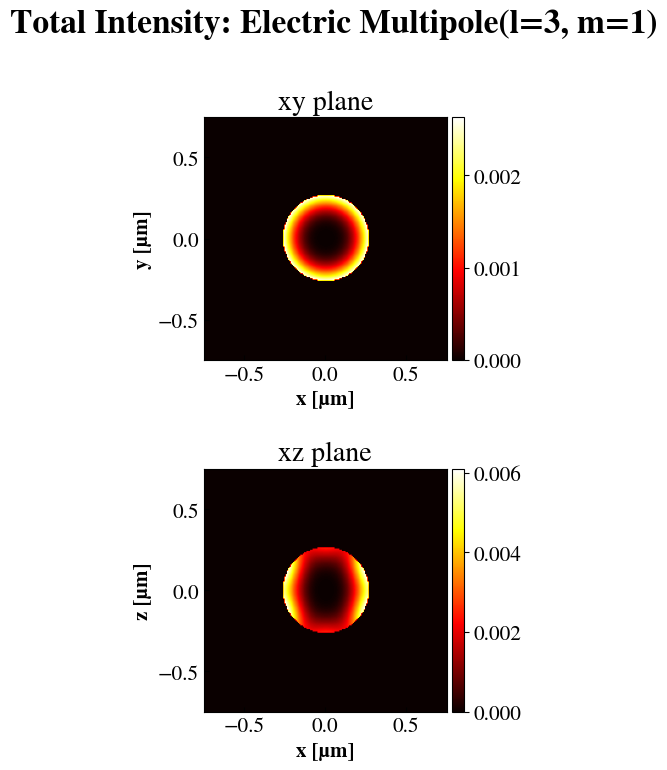

In [26]:
mp.plot_multipoles(3, 1, type = "electric", interaction = "internal", plot = "total", globalnorm = False)

In [23]:
mpp = mp.get_multipoles(2, 0, "both")
magabs = np.sum(np.abs(mpp["electric"][:,0,:,:])**2, axis = 0)*(np.ones_like(mp.R) * (mp.R < 0.25 * mp.R.max()))
print(np.max(magabs))

0.006458635144191081


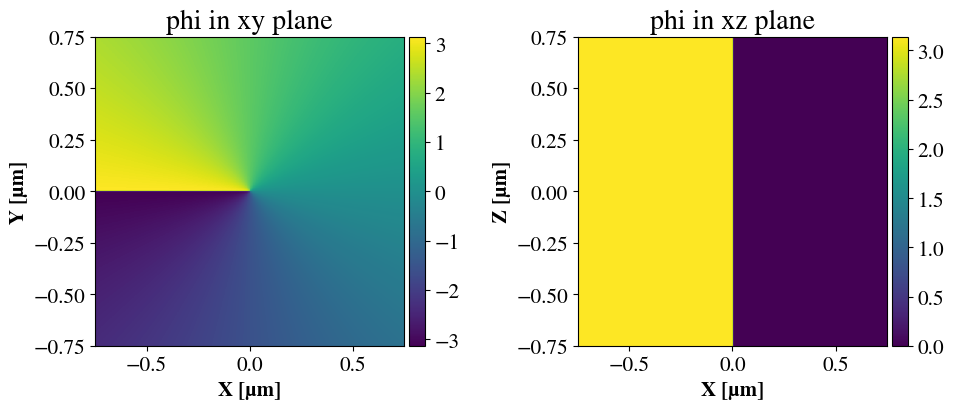

In [162]:
d.show_coord('phi', d.spherical_grid())

0.014348635358974177


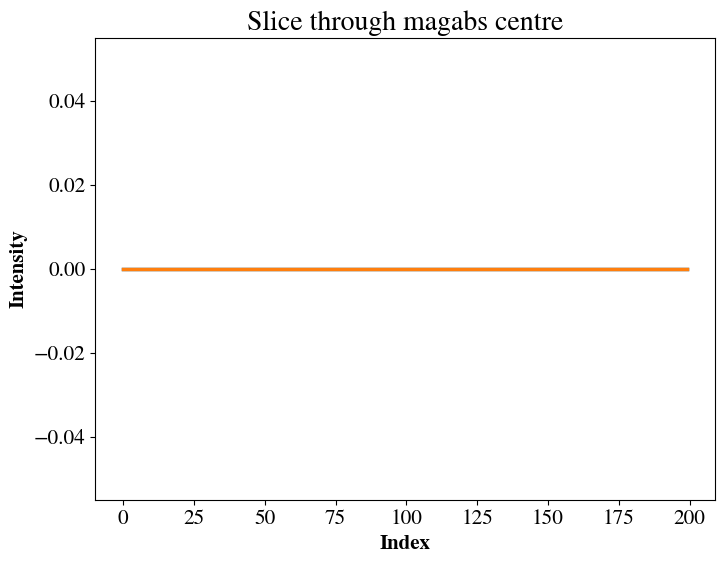

In [73]:
mpp = mp.get_multipoles(2, 1, "bessel")
magabs = np.sum(np.abs(mpp["magnetic"][:,1,:,:])**2, axis = 0)*(np.ones_like(mp.R) * (mp.R < 0.25 * mp.R.max()))
print(np.max(magabs))
magabs.shape
import matplotlib.pyplot as plt

center_idx = magabs.shape[0] // 2
plt.figure(figsize=(8, 6))
plt.plot(magabs.T[:, center_idx])
plt.title("Slice through magabs centre")
plt.xlabel("Index")
plt.ylabel("Intensity")
plt.show()